Mid term Report title


In [76]:
# Import libraries and modules
import yfinance as yf
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime
from dateutil import parser

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SentimentAnalyzer
sentimentAnalyzer = SentimentAnalyzer()


import matplotlib.pyplot as plt
from matplotlib import style

# Show all matplotlib graphs inline
%matplotlib inline  
# using the style for the plot
plt.style.use('dark_background')
# set plot size
plt.rcParams['figure.figsize'] = [30, 15]


In [77]:
#Scope Limits
StartTime = "2012-05-01"
EndTime = "2022-05-01"
TweetLimit = 1000000 #this is roughly 200 MB

# scope of a jump
MinDaysBetweenJumps = 7

StockJumpTriggerRatio = 0.5
StockJumpTriggerPercentage = 1

TwitterJumpTriggerRatio = 1
TwitterJumpTriggerPercentage = 5

#scope of number of tweets
UsingHashTags = True
UsingPhrases = False


# caching folders
TweetCacheFolder_Small = "CachedTweets_Small"
TweetCacheFolder_Large = "CachedTweets_Large"
StockCacheFolder = "CachedStockData"

TweetCacheDict = {}
StockCacheDict = {}

Collect Twitter Data

In [78]:
#what users do we care about

with open("config.json", "r") as file:
	companiesToReview = json.load(file)

In [79]:
def StrToDate(date):
	try:
		date = parser.parse(date)
	except:
		raise Exception("invalid date: " + str(date) + " Of type: " + str(type(date)))
	
	
	date = datetime(date.year, date.month, date.day)
	return date

In [80]:
def GetTweetSentiment(text):
	scores = sentimentAnalyzer.polarity_scores(text)
	return scores["compound"]

In [81]:
def GetTweetsFromAboutCompany(companyData, isLarge=False):

	tweetCacheFolder = TweetCacheFolder_Small
	dictKey = companyData["StockName"]

	if isLarge: 
		tweetCacheFolder =TweetCacheFolder_Large
		dictKey += "_IsLarge"

	if not os.path.isdir(tweetCacheFolder):
		os.mkdir(tweetCacheFolder)

	cachePath = os.path.join(tweetCacheFolder, "tweets_" + companyData["StockName"] + ".csv")

	#dict cache exists
	if dictKey in TweetCacheDict:
		df = TweetCacheDict[dictKey]

	# file cache exists
	else:
		if os.path.exists(cachePath):
			df = pd.read_csv(cachePath)

			

		else:
			# build the query
			query = "("

			twitterUsernames = companyData["TwitterUsernames"]
			twitterHashTags = companyData["TwitterHashTags"]
			twitterPhrases = companyData["TwitterPhrases"]

			for i in range(len(twitterUsernames)):
				query += "from:" + twitterUsernames[i]
				if i < len(twitterUsernames) - 1:
					query += " OR "

			if UsingHashTags:
				query += ") OR ("

				for i in range(len(twitterHashTags)):
					query += twitterHashTags[i]
					if i < len(twitterHashTags) - 1:
						query += " OR "

			if UsingPhrases:
				query += ") OR ("

				for i in range(len(twitterPhrases)):
					query += twitterPhrases[i]
					if i < len(twitterPhrases) - 1:
						query += " OR "

			query += ") since:" + StartTime + " until:" + EndTime + " -filter:links -filter:replies"
			
			# get tweets that match the query
			tweets = []
			for tweet in sntwitter.TwitterSearchScraper(query).get_items():
				
				if TweetLimit > 0 and len(tweets) == TweetLimit:
					break
				else:
					sentiment = GetTweetSentiment(tweet.content)
					tweets.append([tweet.date, tweet.user.username, tweet.content, tweet.replyCount, tweet.retweetCount, tweet.likeCount, tweet.quoteCount, tweet.id, sentiment])

			df = pd.DataFrame(tweets, columns=['Date', 'User', 'Content', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'TweetID', 'Sentiment'])

			# to save to csv as a cache
			df.to_csv(cachePath)

		for i in range(len(df)):
			df["Date"][i] = StrToDate(df["Date"][i])

		df = df.sort_values(by=['Date'])
		TweetCacheDict[dictKey] = df
	


	return df

In [82]:
def LoadStockData(stockTag):

	if not os.path.isdir(StockCacheFolder):
		os.mkdir(StockCacheFolder)

	cachePath = os.path.join(StockCacheFolder, "Stock_" + stockTag + ".csv")

	#dict cache exists
	if stockTag in TweetCacheDict:
		stockDataDf = TweetCacheDict[stockTag]

	# file cache exists
	else:
		if os.path.exists(cachePath):
			stockDataDf = pd.read_csv(cachePath)
			
		else:
			stockDataDf = yf.download(stockTag, start=StartTime, end=EndTime, progress=False)

			#save data to local cache file
			stockDataDf.to_csv(cachePath)


		for i in range(len(stockDataDf)):
			stockDataDf["Date"][i] = StrToDate(stockDataDf["Date"][i])

		stockDataDf = stockDataDf.sort_values(by=['Date'])
		TweetCacheDict[stockTag] = stockDataDf

	
	return stockDataDf

In [83]:
def CreateMovingAverage(df, columnToAverage, averageLength):

	movingAverage = []
	movingAverageUpperQuantile = []
	movingAverageLowerQuantile = []

	rows = df.loc[:,columnToAverage]
	for i in range(len(rows)):

		# get window
		if i < averageLength:
			window = [0]
		else:
			window = rows[i - averageLength : i]

		# calculate moving avg
		windowAverage = round(sum(window) / averageLength, 2)
		movingAverage.append(windowAverage)

		# calculate UpperQuantile
		upperQuantile = np.quantile(window, 0.9)
		movingAverageUpperQuantile.append(upperQuantile)

		# calculate LowerQuantile
		lowerQuantile = np.quantile(window, 0.1)
		movingAverageLowerQuantile.append(lowerQuantile)

	df.insert(len(df.columns), columnToAverage + "MA_" + str(averageLength), movingAverage, allow_duplicates=True)
	df.insert(len(df.columns), columnToAverage + "MA_" + str(averageLength) + "_UpperQuantile", movingAverageUpperQuantile, allow_duplicates=True)
	df.insert(len(df.columns), columnToAverage + "MA_" + str(averageLength) + "_LowerQuantile", movingAverageLowerQuantile, allow_duplicates=True)
	return

In [84]:
def DetectValueJumping(df, column, lastValueColumn, currentValueColumn, jumpTriggerRatio, jumpTriggerPercentage):
	isValueJumping = []

	for i in range(len(df)):

		# get window
		if i < 45: #skip the first few days as the moving averages take a few days to settle
			isJump = False
		else:
			upperQuantile = df[column + "MA_7MA_30_UpperQuantile"][i]
			lowerQuantile = df[column + "MA_7MA_30_LowerQuantile"][i]
			lastValue = df[lastValueColumn][i]
			currentValue = df[currentValueColumn][i]

			interQuantileRange = upperQuantile - lowerQuantile
			triggerRange = jumpTriggerRatio * interQuantileRange

			meantRatio = currentValue > upperQuantile + triggerRange or currentValue < lowerQuantile - triggerRange

			meantPercentage = False
			if lastValue != 0:
				meantPercentage = abs(lastValue - currentValue) / lastValue > jumpTriggerPercentage / 100
			
			isJump = meantRatio and meantPercentage

		isValueJumping.append(isJump)

	df.insert(len(df.columns), column + "_IsJumping", isValueJumping, allow_duplicates=True)

	return

def CreateStockTrendData(stockData):

	CreateMovingAverage(stockData, "Volume", 3)
	CreateMovingAverage(stockData, "Volume", 7)
	CreateMovingAverage(stockData, "VolumeMA_7", 30)

	CreateMovingAverage(stockData, "Open", 3)
	CreateMovingAverage(stockData, "Open", 7)
	CreateMovingAverage(stockData, "OpenMA_7", 30)

	DetectStockJumps(stockData)

	return

def DetectStockJumps(stockData):

	DetectValueJumping(stockData, "Volume", "VolumeMA_7", "VolumeMA_3",
		StockJumpTriggerRatio, StockJumpTriggerPercentage)
	DetectValueJumping(stockData, "Open", "OpenMA_3", "Open",
		StockJumpTriggerRatio, StockJumpTriggerPercentage)

	
	bothJumped = stockData["Volume_IsJumping"] * stockData["Open_IsJumping"]
	stockData.insert(len(stockData.columns), "Both_IsJumping", bothJumped, allow_duplicates=True)

	eitherJumped = stockData["Volume_IsJumping"] + stockData["Open_IsJumping"]
	stockData.insert(len(stockData.columns), "Either_IsJumping", eitherJumped, allow_duplicates=True)

	return

def DetectTweetJumps(tweetData):
	CreateMovingAverage(tweetData, "avgSentiment", 3)
	CreateMovingAverage(tweetData, "avgSentiment", 7)
	CreateMovingAverage(tweetData, "avgSentiment", 30)
	CreateMovingAverage(tweetData, "avgSentimentMA_7", 30)

	DetectValueJumping(tweetData, "avgSentiment", "avgSentimentMA_7MA_30", "avgSentimentMA_7",
		TwitterJumpTriggerRatio, TwitterJumpTriggerPercentage)

	return


In [85]:
def GetValueJumpsDates(stockData, jumpColumn):

	dates = []
	daysSinceLastJump = MinDaysBetweenJumps

	for i in range(len(stockData)):
		daysSinceLastJump += 1

		isJump = stockData[jumpColumn][i]

		if isJump and daysSinceLastJump >= MinDaysBetweenJumps:
			dates.append(stockData["Date"][i])
			daysSinceLastJump = 0

	return dates

In [86]:
#down load all needed data to local cache
for companyData in companiesToReview:
	GetTweetsFromAboutCompany(companyData)

	tweetData = GetTweetsFromAboutCompany(companyData, isLarge=True)

	DetectTweetJumps(tweetData)

	companyData["TweetJumpDates"] = GetValueJumpsDates(tweetData, "avgSentiment_IsJumping")
	

	stockData = LoadStockData(companyData["Tag"])
	CreateStockTrendData(stockData)
	companyData["StockJumpDates"] = GetValueJumpsDates(stockData, "Both_IsJumping")



C:\Users\LOUIE~1.JON\AppData\Local\Temp/ipykernel_28560/3196593681.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"][i] = StrToDate(df["Date"][i])
C:\Users\LOUIE~1.JON\AppData\Local\Temp/ipykernel_28560/3196593681.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"][i] = StrToDate(df["Date"][i])
C:\Users\LOUIE~1.JON\AppData\Local\Temp/ipykernel_28560/3178137230.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

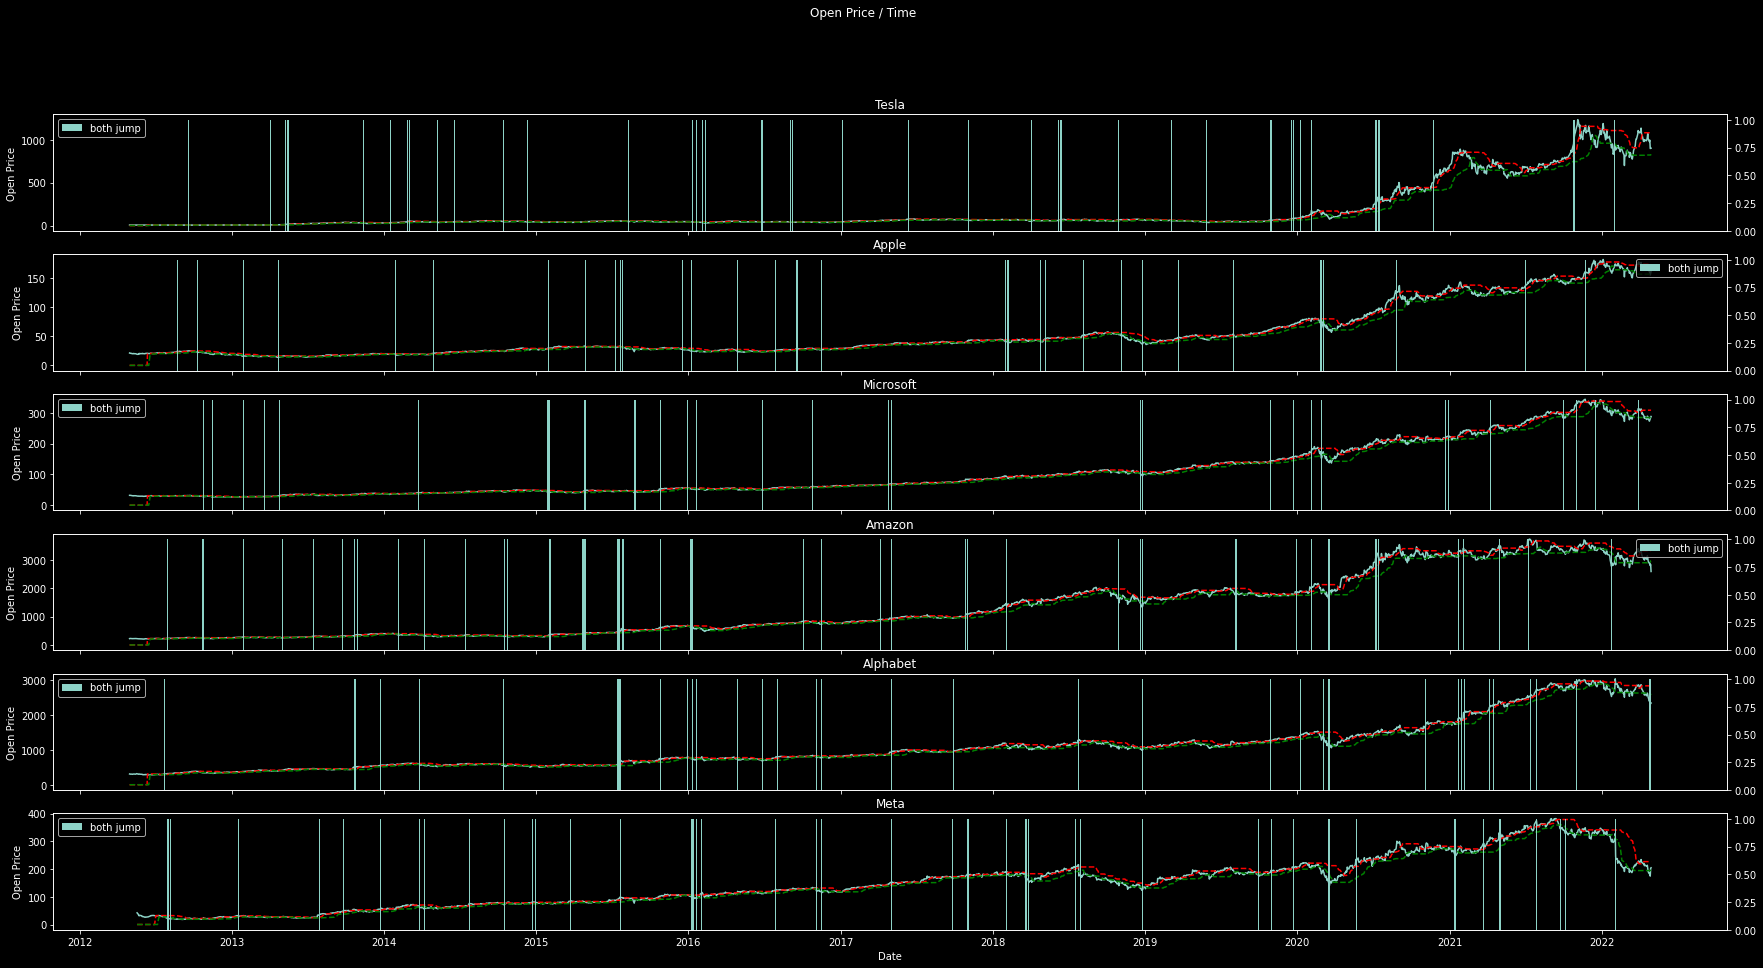

In [87]:
numCharts = 6

fig, axs = plt.subplots(numCharts, sharex=True)
fig.suptitle("Open Price / Time")

for i in range(numCharts):
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	axs[i].set_title(companiesToReview[i]["StockName"])
	axs[i].plot(stockData["Date"], stockData["Open"], label = "Open")
	axs[i].plot(stockData["Date"], stockData["OpenMA_7MA_30_UpperQuantile"], 'r--', label = "OpenMA_7MA_30_UpperQuantile")
	axs[i].plot(stockData["Date"], stockData["OpenMA_7MA_30_LowerQuantile"], 'g--', label = "OpenMA_7MA_30_LowerQuantile")
	
	axs[i].set(xlabel='Date', ylabel='Open Price')
	axs[i].label_outer()

	ax2 = axs[i].twinx()
	# ax2.bar(stockData["Date"], stockData["Open_IsJumping"], label="open jump")
	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], label="both jump")

	ax2.legend()
plt.show()

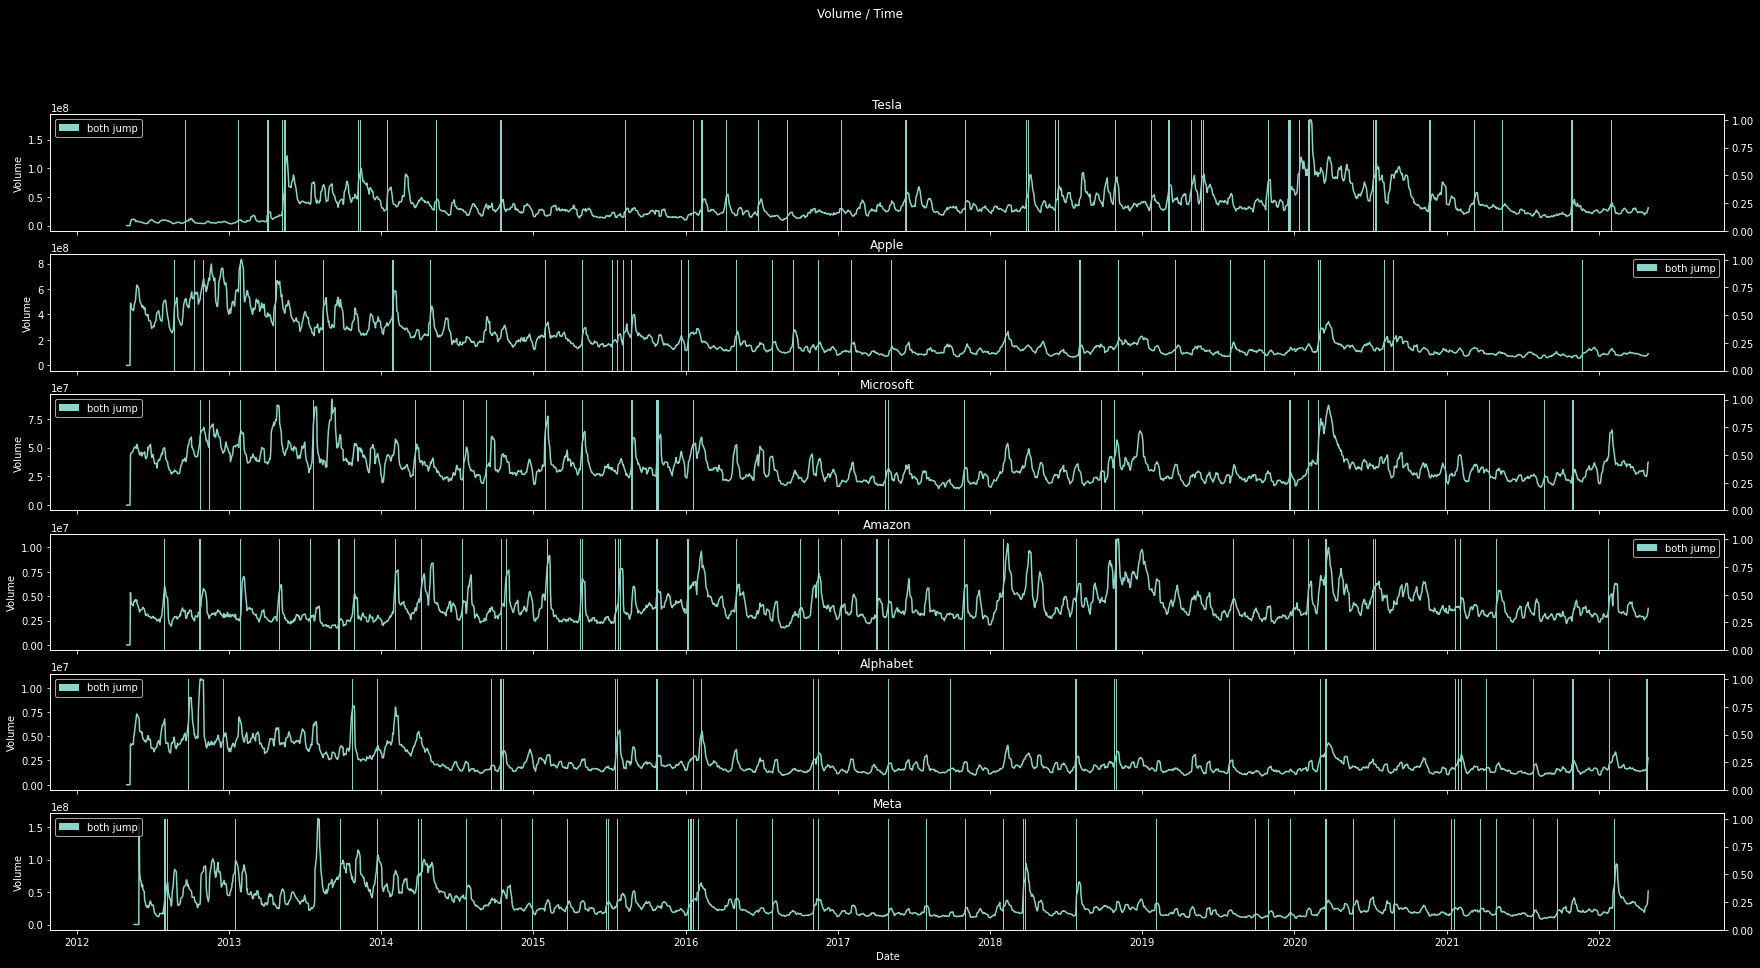

In [88]:
numCharts = 6

fig, axs = plt.subplots(numCharts, sharex=True)
fig.suptitle("Volume / Time")

for i in range(numCharts):
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	axs[i].set_title(companiesToReview[i]["StockName"])
	axs[i].plot(stockData["Date"], stockData["VolumeMA_7"], label = "VolumeMA_7")
	# axs[i].plot(stockData["Date"], stockData["VolumeMA_7MA_30_UpperQuantile"], 'r--', label = "VolumeMA_7MA_30_UpperQuantile")
	# axs[i].plot(stockData["Date"], stockData["VolumeMA_7MA_30_LowerQuantile"], 'g--', label = "VolumeMA_7MA_30_LowerQuantile")
	
	axs[i].set(xlabel='Date', ylabel='Volume')
	axs[i].label_outer()

	ax2 = axs[i].twinx()
	
	# ax2.bar(stockData["Date"], stockData["Volume_IsJumping"], label="volume jump")
	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], label="both jump")

	ax2.legend()

plt.show()

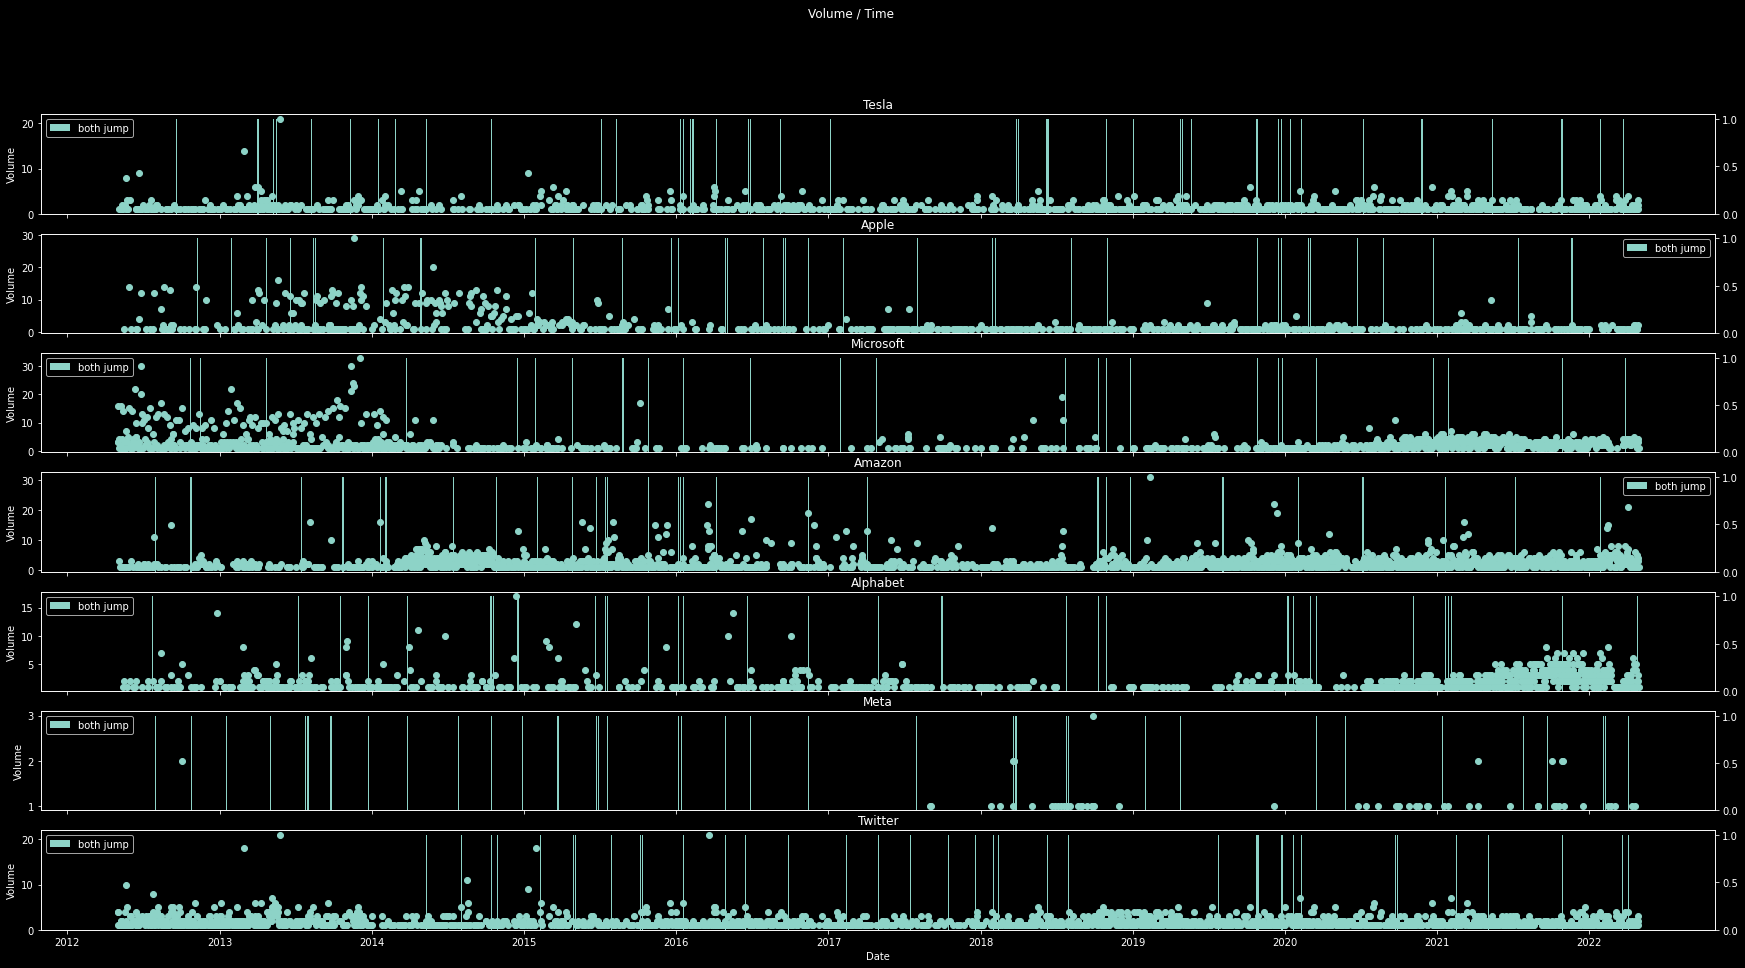

In [89]:
numCharts = 7

fig, axs = plt.subplots(numCharts, sharex=True)
fig.suptitle("Volume / Time")

for i in range(numCharts):

	tweetData = GetTweetsFromAboutCompany(companiesToReview[i])
	
	grouped = tweetData.groupby(["Date"]).size().reset_index(name='counts')

	axs[i].set_title(companiesToReview[i]["StockName"])
	axs[i].scatter(grouped["Date"], grouped["counts"], label = "Volume")
	
	axs[i].set(xlabel='Date', ylabel='Volume')
	axs[i].label_outer()
	
	ax2 = axs[i].twinx()
	
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], label="both jump")
	ax2.legend()


plt.show()

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

positive sentiment: compound score >= 0.05
neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
negative sentiment: compound score <= -0.05
NOTE: The compound score is the one most commonly used for sentiment analysis by most researchers, including the authors.

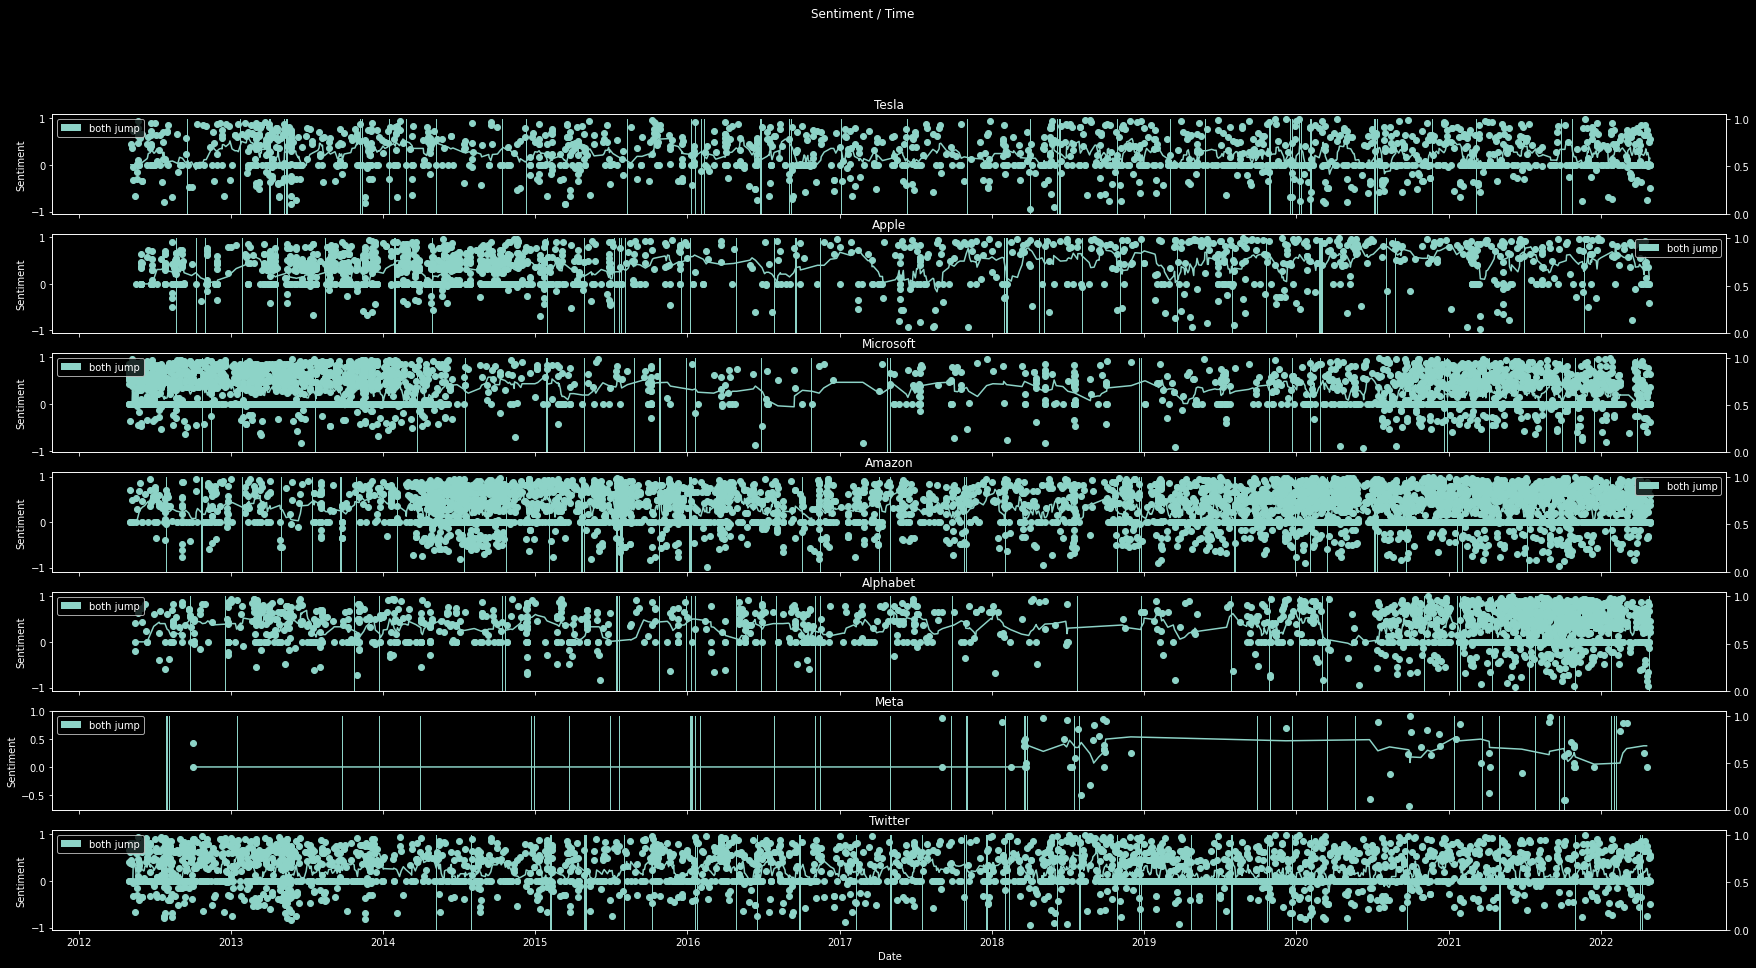

In [90]:
numCharts = 7

fig, axs = plt.subplots(numCharts, sharex=True)
fig.suptitle("Sentiment / Time")

for i in range(numCharts):

	tweetData = GetTweetsFromAboutCompany(companiesToReview[i])
	
	axs[i].set_title(companiesToReview[i]["StockName"])

	avgSentiment = tweetData.groupby("Date")['Sentiment'].mean().reset_index(name='Sentiment')
	CreateMovingAverage(avgSentiment, "Sentiment", 7)
	axs[i].plot(avgSentiment["Date"], avgSentiment["SentimentMA_7"], label = "Sentiment MA_7")

	
	axs[i].scatter(tweetData["Date"], tweetData["Sentiment"], label = "Sentiment")
	
	axs[i].set(xlabel='Date', ylabel='Sentiment')
	axs[i].label_outer()
	
	ax2 = axs[i].twinx()
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], label="both jump")
	ax2.legend()


plt.show()

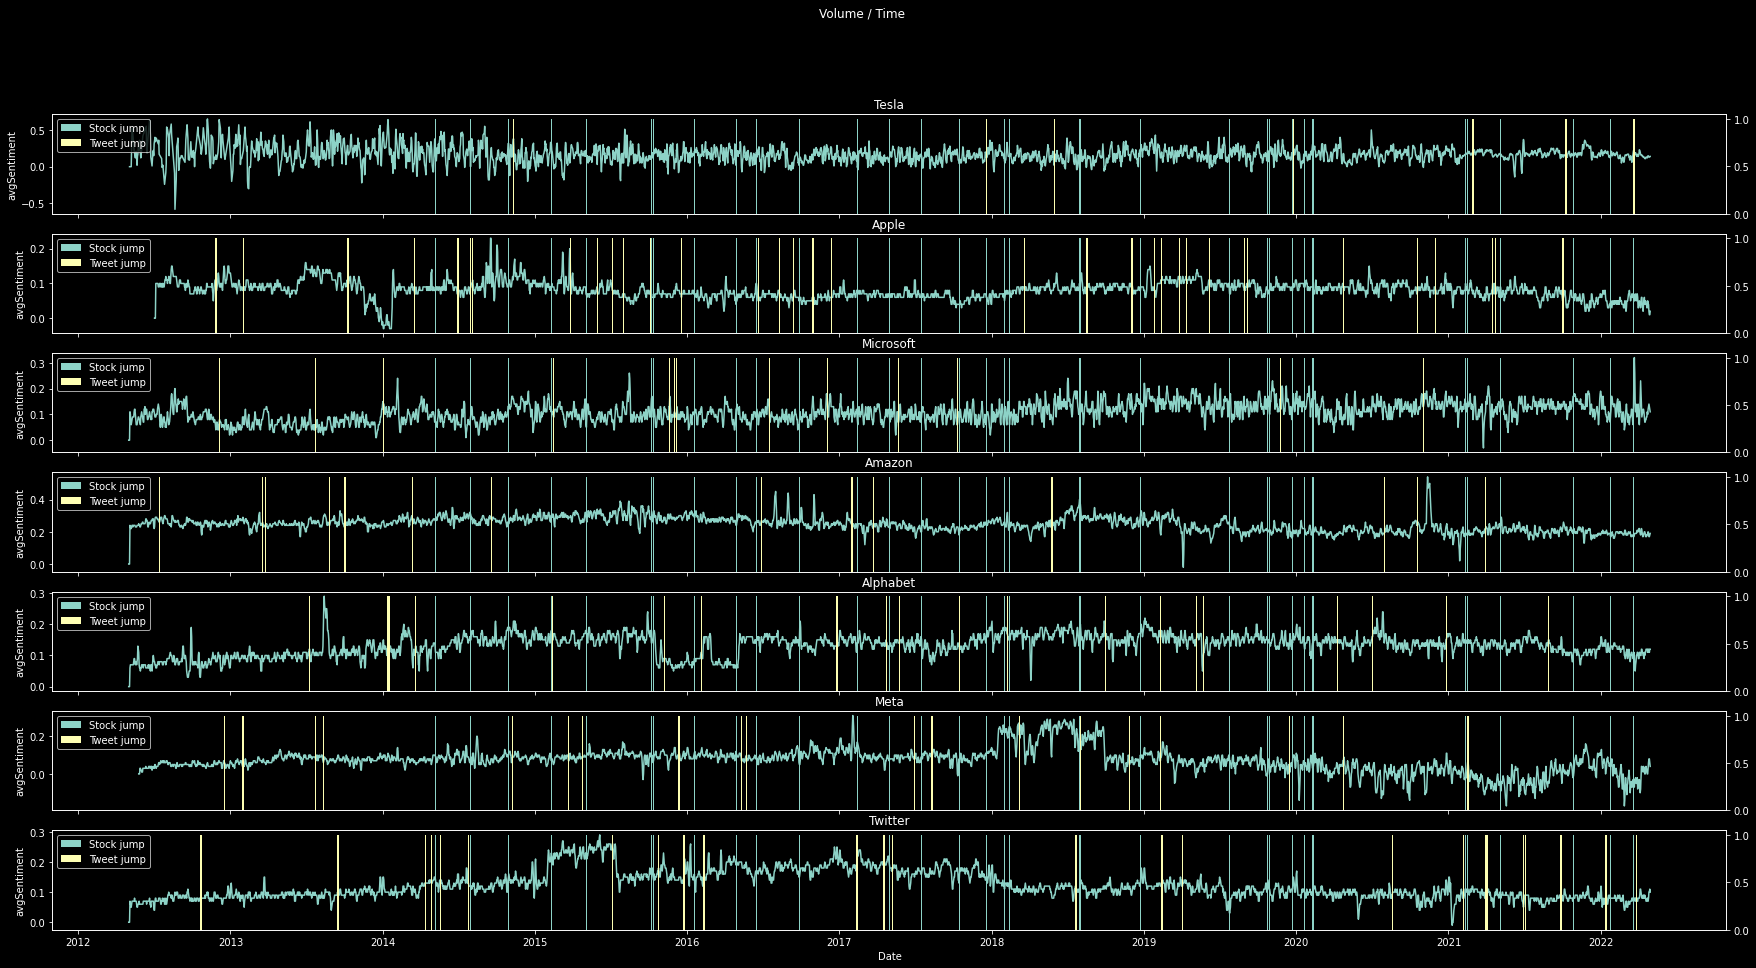

In [91]:
numCharts = 7

fig, axs = plt.subplots(numCharts, sharex=True)
fig.suptitle("Volume / Time")

for i in range(numCharts):

	tweetData = GetTweetsFromAboutCompany(companiesToReview[i], isLarge=True)
	
	axs[i].set_title(companiesToReview[i]["StockName"])

	CreateMovingAverage(tweetData, "avgSentiment", 7)

	
	# axs[i].scatter(tweetData["Date"], tweetData["avgSentiment"], label = "avgSentiment")
	axs[i].plot(tweetData["Date"], tweetData["avgSentimentMA_3"], label = "avgSentiment MA_7")

	axs[i].set(xlabel='Date', ylabel='avgSentiment')
	axs[i].label_outer()
	
	ax2 = axs[i].twinx()
	# stockData = LoadStockData(companiesToReview[i]["Tag"])

	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], label="Stock jump")
	ax2.bar(tweetData["Date"], tweetData["avgSentiment_IsJumping"], label="Tweet jump")
	ax2.legend()


plt.show()

In [92]:
def GetDaysBetweenTweetAndStock(tweetDates, stockDates):
	tweetDates = sorted(tweetDates)
	stockDates = sorted(stockDates)

	daysToJumpList = []
	lastStockIndex = 0
	for tweetDate in tweetDates:

		for i in range(lastStockIndex, len(stockDates)):
			
			stockDate = stockDates[i]
			delta = (stockDate - tweetDate).days
			if delta >= 0:
				lastStockIndex = i
				daysToJumpList.append(delta)
				break



	return daysToJumpList

def AvgDaysBetweenJumps(dates):
	dates = sorted(dates)

	deltas = []
	for i in range(len(dates) - 1):
		deltas.append((dates[i+1] - dates[i]).days)
	return sum(deltas) / len(deltas)

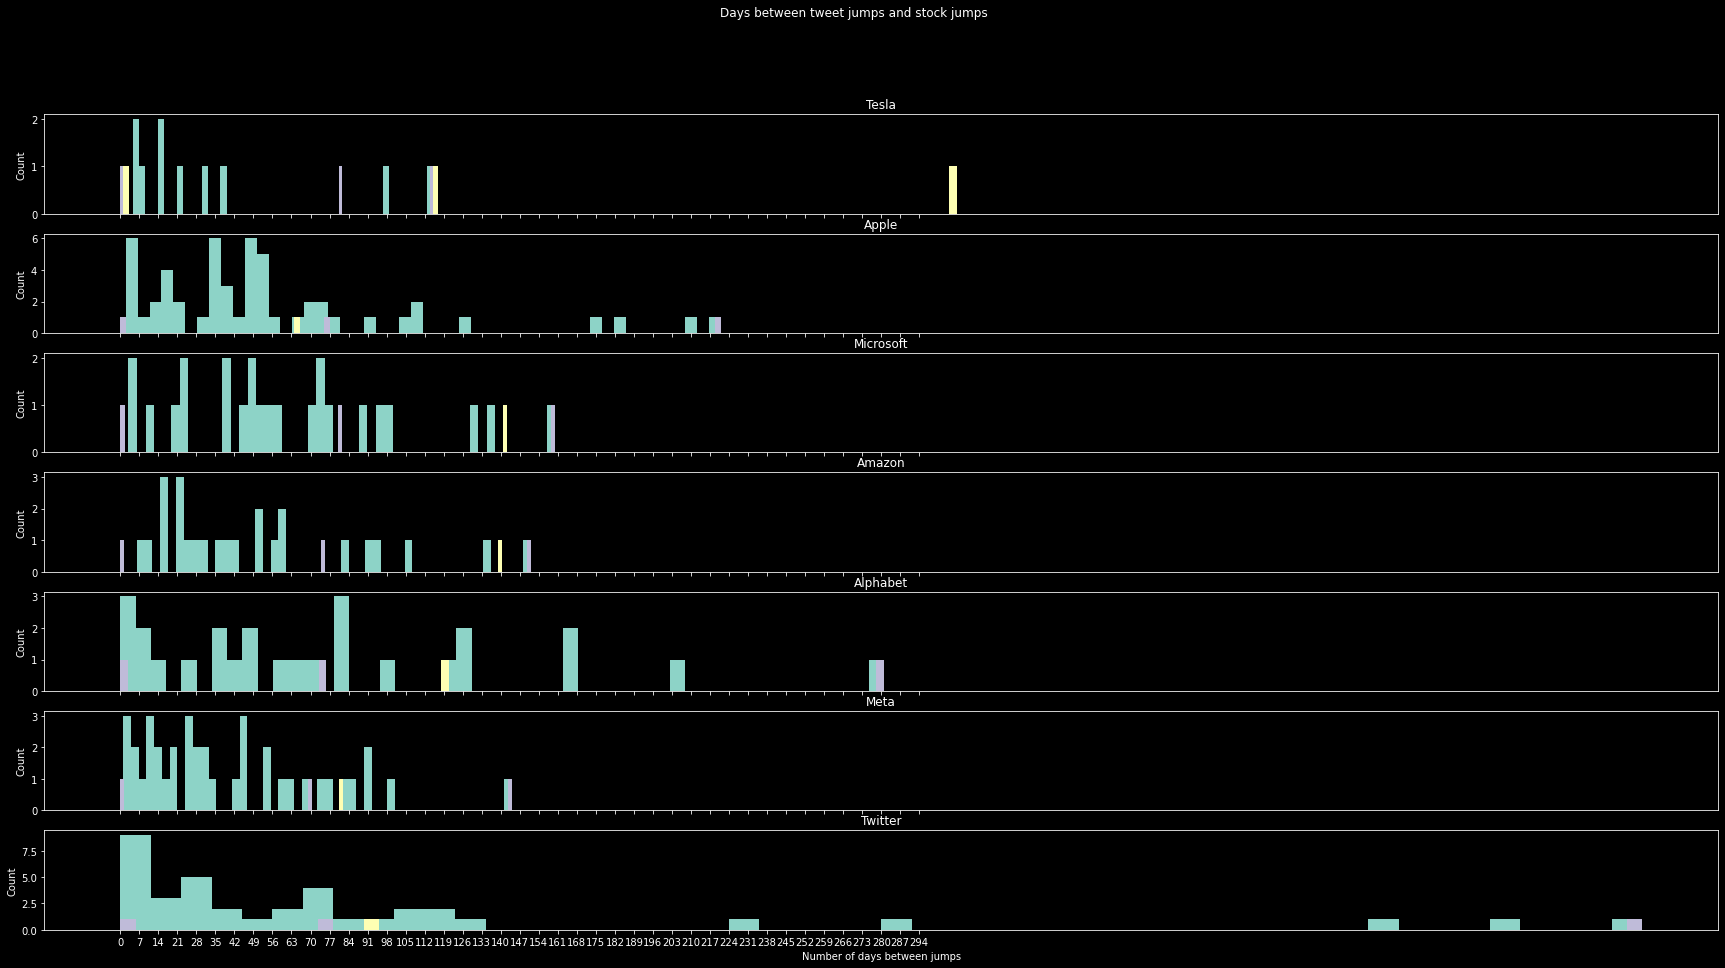

In [93]:
# get the number of days between each tweeter jump and stock jump

fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Days between tweet jumps and stock jumps")

for i in range(7):
	companyData = companiesToReview[i]
	axs[i].set_title(companyData["StockName"])

	tweetJumpDates = companyData["TweetJumpDates"]
	stockJumpDates = companyData["StockJumpDates"]
	daysToJumpList = GetDaysBetweenTweetAndStock(tweetJumpDates, stockJumpDates)

	avgGapBetweenTweetJumps = AvgDaysBetweenJumps(tweetJumpDates)
	avgGapBetweenStockJumps = AvgDaysBetweenJumps(stockJumpDates)
	
	axs[i].hist(daysToJumpList, 50)

	axs[i].hist([0, avgGapBetweenTweetJumps, max(daysToJumpList)], 100)
	axs[i].hist([0, avgGapBetweenStockJumps, max(daysToJumpList)], 100)


	axs[i].set(xlabel='Number of days between jumps', ylabel='Count')
	axs[i].label_outer()
	axs[i].xaxis.set_ticks(np.arange(0, 300, 7))

plt.show()